# User Defined Functions

*User defined functions*, UDFs for short, allow you to perform complex mathematical calculations involving data layers.

The following map shows *for each pixel* the first day of 2017 during which for the first time of that year the temperature crossed 283 Kelvin (49.73 F). (The day of the year is given numerically, i.e. January first is 1, February first 32 and so on.) As one would expect, the South-East and Southern California already show such temperatures at the beginning of the year, while warmer temperatures reach the Rockies during early Summer.

![temperature_above_283_usa_2017.png](temperature_above_283_usa_2017.png)

This map was created with a single Geospatial Analytics API call using a user defined function. Similarly it is possible to evaluate a decision tree or a fully connected neural network pixel-wise for a large area using a UDF and thus push the evaluation of a machine learning model into Geospatial Analytics queries. While UDFs can get very complex, we start with a very simple example.

## A Simple UDF - Mean Maximum Temperature

Readers of the :ref:`tutorial-api-aggregation-and-filtering` tutorial know how to calculate e.g. the total amount of precipitation during a single calendar year. However, a single ``aggregation`` call is not able to calculate the mean maximum temperature on January first. In other words, let's assume we want to take the average over "maximum temperature 1981-01-01", "maximum temperature 1982-01-01", "maximum temperature 1983-01-01". The following query accomplishes this *without any local post-processing*.


2021-12-06 14:55:18 - paw - INFO - The '<class 'str'>' value 'false' was converted to a boolean 'False'.
2021-12-06 14:55:18 - paw - INFO - The '<class 'str'>' value 'false' was converted to a boolean 'False'.
2021-12-06 14:55:18 - paw - INFO - The '<class 'str'>' value 'false' was converted to a boolean 'False'.
2021-12-06 14:55:18 - paw - INFO - TASK: submit_check_status_and_download STARTING.
2021-12-06 14:55:18 - paw - INFO - The query was successfully submitted with the id: 1638766800_35718348.
2021-12-06 14:55:19 - paw - INFO - The query 1638766800_35718348 has the status Queued.
2021-12-06 14:55:49 - paw - INFO - The query 1638766800_35718348 has the status Initializing.
2021-12-06 14:56:20 - paw - INFO - The query 1638766800_35718348 has the status Running.
2021-12-06 14:56:50 - paw - INFO - The query 1638766800_35718348 has the status Running.
2021-12-06 14:57:21 - paw - INFO - The query 1638766800_35718348 has the status Writing.
2021-12-06 14:57:51 - paw - INFO - The query 1

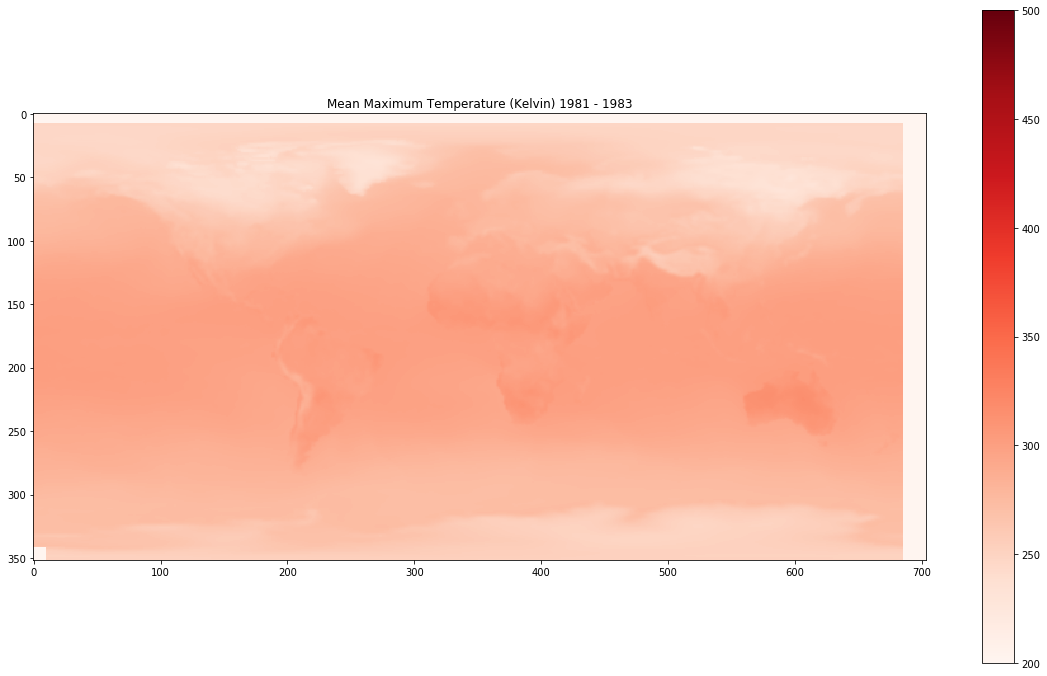

In [18]:
import os
import pandas as pd
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt
import ibmpairs.authentication as authentication
import ibmpairs.client as client
import ibmpairs.query as query

# Best practice is not to include secrets in source code so we read 
# a user name and password from operating system environment variables. 
# You could set the user name and password in-line here but we don't  
# recommend it for security reasons.
EIS_USERNAME=os.environ.get('EIS_USERNAME')
EIS_APIKEY=os.environ.get('EIS_APIKEY')

# Create an authentication object with credentials.
credentials  = authentication.OAuth2(username = EIS_USERNAME,
                                     api_key  = EIS_APIKEY)

# Add the credentials object to a client object.
eis_client = client.Client(authentication = credentials)

query_json = {"layers": [
      {
          "aggregation": "Max",
          "alias": "data_19810101",
          "id": "48869",
          "output": "false",
          "temporal": {"intervals": [
              {"end": "1981-01-02T00:00:01Z", "start": "1981-01-01T00:00:01Z"}
          ]}, "type": "raster"
      },
      {
          "aggregation": "Max",
          "alias": "data_19820101",
          "id": "48869",
          "output": "false",
          "temporal": {"intervals": [
              {"end": "1982-01-02T00:00:01Z", "start": "1982-01-01T00:00:01Z"}
          ]}, "type": "raster"
      },
      {
          "aggregation": "Max",
          "alias": "data_19830101",
          "id": "48869",
          "output": "false",
          "temporal": {"intervals": [
              {"end": "1983-01-02T00:00:01Z", "start": "1983-01-01T00:00:01Z"}
          ]},
          "type": "raster"},
      {
          "alias": "result_01_01",
          "expression": "(($data_19810101 + $data_19820101) + $data_19830101) / 3.0"}],
          "name": "math_sample",
          "spatial": {"coordinates": ["-90.0", "-179.9", "90.0", "179.9"], "type": "square"},
          "temporal": {"intervals": [
              {"end": "2016-01-02T00:00:00Z", "start": "2016-01-01T00:00:00Z"}
      ]}
  }

# Submit the query
query_result = query.submit_check_status_and_download(query_json)

# Find layer files to load from downloaded zip.
files = query_result.list_files()
print("Downloaded file = '" + os.path.basename(files[0]) + "'")

# From here you are on your own and can process the downloaded files in
# whatever way is appropriate for you workflow.
# For example, here we open the first file in the files list (there is
# only one file in the list for this query) using the Python Image Library (PIL), 
# we convert it to a numpy array and display it using matplotlib
array = np.array(PIL.Image.open(files[0]))
plt.figure(figsize = (20, 12))
plt.imshow(array, cmap = 'Reds', vmin = 200, vmax = 500)
plt.title('Mean Maximum Temperature (Kelvin) 1981 - 1983')
plt.colorbar()
plt.show()

The above JSON query has four entries in the ``layers`` block. The first three of these take the form
```
  {
      "aggregation": "Max",
      "alias": "data_19810101",
      "id": "48869",
      "output": "false",
      "temporal": {"intervals": [
          {"end": "1981-01-02T00:00:01Z", "start": "1981-01-01T00:00:01Z"}
      ]}, "type": "raster"
  }
```

Here, we are requesting three hourly maximum temperature data from the ECMWF Interim Reanalysis (ID 48869) for January 1, 1981, and take the maximum (``"aggregation" : "Max"``). Moreover, we assign an alias to the result for later use (``"alias" : "data_19810101"``) and instruct Geospatial Analytics not to generate a GeoTIFF (``"output" : "false"``). The latter reduces both the amount of data transferred at the end while also improving query performance since GeoTIFF generation can be a time consuming process. One could refer to layers with this flag set to ``false`` as *virtual layers*.

Once we have created the aliases ``data_19810101``, ``data_19820101`` and ``data_19810103``, we can perform mathematical operations on them by using them as the ingredients of a user defined function. To do so, we have introduced a fourth block:

```
  {
      "alias": "result_01_01",
      "expression": "(($data_19810101 + $data_19820101) + $data_19830101) / 3.0"
  }
```

The user defined function is defined as the value of the ``expression`` key. Here, we are taking a simple average over all three values. The list of possible operations includes:

| Function | Description |
| -------- | ----------- |
| math:max(\$A,\$B) | Maximum |
| math:abs(\$A)    | Absolute value |
| math:cos(\$A)    | Cosine |
| math:acos(\$A)   | Inverse cosine |
| math:exp(\$A)    | Exponential |
| \$A  \?  \$B \: \$C    | If A then B else C |

<div class="alert alert-info">
Aliases have to comply with the following regular expression: ``^[0-9a-zA-Z_]+$``. In other words, aliases admit alphanumeric characters as well as underlines.
</div>
